#### This is a testing notebook to run some cleaning and checking of the current database

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import datetime
import quandl

In [2]:
import matplotlib.pyplot as plt

In [3]:
% matplotlib inline

In [56]:
import sqlite3

In [57]:
sqlite_file = 'securities_master_db.sqlite'

In [6]:
# Copied in the relevant functions from database creation

def create_df_crypto(symbol, curr='USD', limit=2500):
    ''' This function takes in a symbol of a cryptocurrency to be
        used with the Cryptocompare API, and returns a formatted dataframe
        for later processing.

        Args: symbol - cryptocurrency symbol
              curr - currency to report in (default USD)
              limit - max number of data points (default 2500)

        Return: df - dataframe of daily price info for symbol
    '''
    # Set url and params for the call to Cryptocompare API
    url = 'https://min-api.cryptocompare.com/data/histoday'
    params = {'fsym': symbol, 'tsym': curr, 'limit': limit}

    # Call API for symbol and put data into pandas dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)

    # Add date column and set to index
    df['Date'] =[datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)

    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)

    return df

def create_df_quandl(symbol, api_key):
    ''' This function takes in a symbol of a futures contract to be used
        with the Quandl API as well as the API key, and returns a formatted
        dataframe for processing.

        Args: symbol - a symbol for a continuous futures contract
              api_key - Quandl API key

        Return: df - dataframe for daily price info for symbol
    '''
    # Quandl API call which puts price data into dataframe
    df = quandl.get('SCF/CME_{s}1_FW'.format(s=symbol), authtoken=api_key)

    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    return df

def generate_df_dict(product_dict, api_key=None):
    ''' This function takes in a dict of product symbols mapped to
        information about the product  and a Quandl API key and returns
        a dict object with the symbols as keys and a dataframe of price
        info as values.

        Args: product_dict - a dict of symbols for products with maps to
                             a list of info
              api_key - Quandl API key

        Return: df_dict - a dictionary of symbols mapped to dataframes
                          of price info
    '''
    df_dict = {}

    # Iterate through list
    for product, info in product_dict.items():
        # Determine what dataframe creator to use
        if info[0] == 1:
            df = create_df_crypto(product)
        if info[0] == 2:
            df = create_df_quandl(product, api_key)

        df_dict[product] = df

    return df_dict

In [7]:
# Setting up the products, database and api key
# Sqlite3 db info and Quandl key
sqlite_file = 'securities_master_db.sqlite'
api_key = 'Hv95pPh1xQWzt5DFhxS7'

# Dict of all products with maps to data_id, name, sector, and exchange
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
                'HO': [2, 'HeatOil', 'Energy', 'CME'],
                'NG': [2, 'NatGas', 'Energy', 'CME'],
                'GC': [2, 'Gold', 'Metals', 'CME'],
                'SI': [2, 'Silver', 'Metals', 'CME'],
                'AD': [2, 'Aussie', 'Forex', 'CME'],
                'CD': [2, 'Canadien', 'Forex', 'CME'],
                'EC': [2, 'Euro', 'Forex', 'CME'],
                'BP': [2, 'Pound', 'Forex', 'CME'],
                'JY': [2, 'Yen', 'Forex', 'CME'],
                'US': [2, '30-yr', 'Treasuries', 'CME'],
                'C': [2, 'Corn', 'Grains', 'CME'],
                'W': [2, 'Wheat', 'Grains', 'CME'],
                'S': [2, 'Soybeans', 'Grains', 'CME'],
                'ES': [2, 'E-mini', 'Indexes', 'CME'],
                'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
                'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
                'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
                'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
                'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
                'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
                'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
                'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
                'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
                'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

In [8]:
# Create a dict for cryptocurrencies only as these will need to have 0 data deleted
crypto_dict = {prod: info for prod, info in products.items() if info[0] == 1}

In [122]:
df_dict_crypto = generate_df_dict(crypto_dict)

In [10]:
eth = df_dict_crypto['ETH']
eth.head()

,open,high,low,close,volume
Date,,,,,
2012-09-28,0.0,0.0,0.0,0.0,0.0
2012-09-29,0.0,0.0,0.0,0.0,0.0
2012-09-30,0.0,0.0,0.0,0.0,0.0
2012-10-01,0.0,0.0,0.0,0.0,0.0
2012-10-02,0.0,0.0,0.0,0.0,0.0


In [11]:
eth_vol = eth[eth.volume > 1000000.0]
start_date = eth.index[eth.volume > 1000000.0].tolist()[0]
start_date

datetime.date(2016, 3, 4)

In [12]:
eth_vol.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-11,11.25,13.48,11.03,13.25,1669862.35
2016-03-12,13.25,15.18,12.00,15.00,1539173.65
2016-03-13,15.00,15.00,10.50,12.50,1909296.28
2016-03-16,12.92,13.00,10.20,11.14,1442272.97


In [13]:
eth_mil_vol = eth[start_date:]
eth_mil_vol.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-05,11.00,11.90,9.75,10.98,845841.96
2016-03-06,10.98,11.47,9.06,9.50,732233.35
2016-03-07,9.50,10.89,8.49,9.88,592001.58
2016-03-08,9.88,12.00,9.60,11.55,568223.02


In [14]:
eth_mil_vol.describe()

,open,high,low,close,volume
count,748.000000,748.000000,748.000000,748.000000,7.480000e+02
mean,210.007045,220.404813,197.495668,210.709987,1.378416e+08
std,298.505673,313.713006,279.228463,298.654387,2.509972e+08
min,6.690000,7.300000,5.970000,6.690000,1.095651e+05
25%,11.210000,11.592500,10.857500,11.210000,1.290058e+06
50%,25.880000,30.460000,25.105000,28.515000,1.357504e+07
75%,303.217500,311.247500,292.415000,303.655000,1.816108e+08
max,1385.020000,1422.860000,1271.070000,1385.020000,2.034011e+09


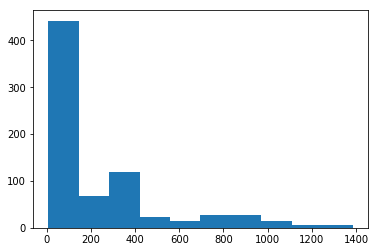

In [15]:
plt.hist(eth_mil_vol.close)
plt.show()

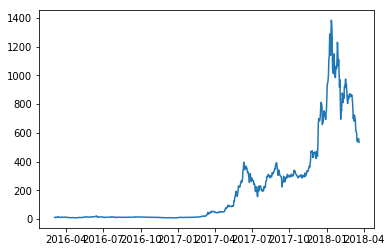

In [16]:
plt.plot(eth_mil_vol.index, eth_mil_vol.close)
plt.show()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  """Entry point for launching an IPython kernel.


{'boxes': [<matplotlib.lines.Line2D at 0x11bffd198>],
 'caps': [<matplotlib.lines.Line2D at 0x11bffdb00>,
 'fliers': [<matplotlib.lines.Line2D at 0x11c068860>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11c068400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11bffd2e8>,
  <matplotlib.lines.Line2D at 0x11bffd6d8>]}

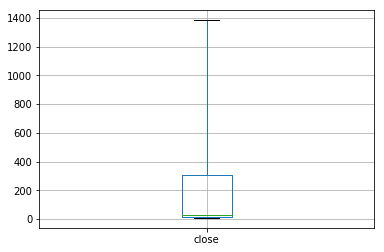

In [17]:
eth_mil_vol.boxplot(column='close', whis='range')

In [18]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute("SELECT * FROM Daily_Prices LIMIT 5")
c.fetchall()

[(1, 2, 'CL', '2005-01-03', 43.1, 43.1, 41.25, 42.12, 69484),
 (2, 2, 'CL', '2005-01-04', 42.18, 44.13, 41.85, 43.91, 100665),
 (3, 2, 'CL', '2005-01-05', 43.9, 44.0, 42.6, 43.39, 91011),
 (4, 2, 'CL', '2005-01-06', 43.39, 45.75, 42.8, 45.56, 122411),
 (5, 2, 'CL', '2005-01-07', 45.5, 46.1, 44.75, 45.43, 99725)]

In [19]:
eth_mil_vol.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-05,11.00,11.90,9.75,10.98,845841.96
2016-03-06,10.98,11.47,9.06,9.50,732233.35
2016-03-07,9.50,10.89,8.49,9.88,592001.58
2016-03-08,9.88,12.00,9.60,11.55,568223.02


In [20]:
conn.close()

In [21]:
eth.head()

,open,high,low,close,volume
Date,,,,,
2012-09-28,0.0,0.0,0.0,0.0,0.0
2012-09-29,0.0,0.0,0.0,0.0,0.0
2012-09-30,0.0,0.0,0.0,0.0,0.0
2012-10-01,0.0,0.0,0.0,0.0,0.0
2012-10-02,0.0,0.0,0.0,0.0,0.0


In [22]:
test_df = eth.ix[start_date:]
test_df.head()

,open,high,low,close,volume
Date,,,,,
2016-03-04,9.96,12.00,9.75,11.00,1726260.37
2016-03-05,11.00,11.90,9.75,10.98,845841.96
2016-03-06,10.98,11.47,9.06,9.50,732233.35
2016-03-07,9.50,10.89,8.49,9.88,592001.58
2016-03-08,9.88,12.00,9.60,11.55,568223.02


In [26]:
def volume_filtered_df(df, min_volume=1000000):
    ''' This function takes in a dataframe of daily price data and a min_volume and returns
        the dataframe from the first data point that achieves the min_volume threshold on.
        
        Args: df - daily price dataframe for specific product
              min_volume - the min volume threshold for using daily price data
              
        Return: df - modified dataframe to include only relevant data
    '''
    # Find the first data point that reaches the volume threshold
    start_date = df.index[df.volume > min_volume].tolist()[0]
    
    return df[start_date:]

In [27]:
xrp = df_dict_crypto['XRP']
xrp.head()

,open,high,low,close,volume
Date,,,,,
2012-09-28,0.0,0.0,0.0,0.0,0.0
2012-09-29,0.0,0.0,0.0,0.0,0.0
2012-09-30,0.0,0.0,0.0,0.0,0.0
2012-10-01,0.0,0.0,0.0,0.0,0.0
2012-10-02,0.0,0.0,0.0,0.0,0.0


In [28]:
xrp_cleaned = volume_filtered_df(xrp)
xrp_cleaned.head()

,open,high,low,close,volume
Date,,,,,
2017-03-23,0.01100,0.01182,0.00815,0.01062,1558480.67
2017-03-24,0.01062,0.01084,0.00879,0.00888,650956.80
2017-03-25,0.00888,0.00982,0.00888,0.00937,230824.07
2017-03-26,0.00937,0.01025,0.00900,0.00943,403512.31
2017-03-27,0.00943,0.00965,0.00906,0.00955,237326.87


In [29]:
print(len(xrp), len(xrp_cleaned))

2001 364


In [40]:
xrp_cleaned['std'] = ((xrp_cleaned['close'] - xrp_cleaned['close'].mean()).apply(abs)) / xrp_cleaned['close'].std()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
xrp_cleaned['close'].mean()

0.4651088736263738

In [34]:
xrp_cleaned['new'] = [0]*len(xrp_cleaned)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
xrp_cleaned['close'].std()

0.5295699427674778

In [39]:
((xrp_cleaned['close'] - xrp_cleaned['close'].mean()).apply(abs)) / xrp_cleaned['close'].std()

Date
2017-03-23    0.858223
2017-03-24    0.861508
2017-03-25    0.860583
2017-03-26    0.860470
2017-03-27    0.860243
2017-03-28    0.859110
2017-03-29    0.852161
2017-03-30    0.837866
2017-03-31    0.836733
2017-04-01    0.762145
2017-04-02    0.817831
2017-04-03    0.806766
2017-04-04    0.811071
2017-04-05    0.815584
2017-04-06    0.808125
2017-04-07    0.810769
2017-04-08    0.813677
2017-04-09    0.813998
2017-04-10    0.815660
2017-04-11    0.813035
2017-04-12    0.813658
2017-04-13    0.815055
2017-04-14    0.814432
2017-04-15    0.815849
2017-04-16    0.815339
2017-04-17    0.816321
2017-04-18    0.820966
2017-04-19    0.821646
2017-04-20    0.814923
2017-04-21    0.818606
                ...   
2018-02-20    0.917898
2018-02-21    0.803088
2018-02-22    0.897126
2018-02-23    0.822915
2018-02-24    0.823482
2018-02-25    0.877110
2018-02-26    0.873333
2018-02-27    0.793457
2018-02-28    0.850485
2018-03-01    0.818006
2018-03-02    0.818194
2018-03-03    1.010048
2018-0

In [41]:
xrp_cleaned.head()

,open,high,low,close,volume,std,new
Date,,,,,,,
2017-03-23,0.01100,0.01182,0.00815,0.01062,1558480.67,0.858223,0
2017-03-24,0.01062,0.01084,0.00879,0.00888,650956.80,0.861508,0
2017-03-25,0.00888,0.00982,0.00888,0.00937,230824.07,0.860583,0
2017-03-26,0.00937,0.01025,0.00900,0.00943,403512.31,0.860470,0
2017-03-27,0.00943,0.00965,0.00906,0.00955,237326.87,0.860243,0


In [44]:
xrp_outliers = xrp_cleaned[xrp_cleaned['std'] > 1.5]

In [45]:
len(xrp_outliers)

30

In [46]:
xrp_outliers

,open,high,low,close,volume,std,new
Date,,,,,,,
2017-12-27,1.21,1.31,1.1000,1.26,3.468453e+08,1.501013,0
2017-12-28,1.26,1.97,1.2500,1.93,1.092825e+09,2.766190,0
2017-12-29,1.93,2.44,1.7700,1.86,1.565229e+09,2.634007,0
2017-12-30,1.86,2.09,1.6100,1.98,5.142730e+08,2.860606,0
2017-12-31,1.98,2.09,1.8100,2.05,2.327574e+08,2.992789,0
2018-01-01,2.05,2.21,1.8900,2.19,4.186053e+08,3.257155,0
2018-01-02,2.19,2.85,2.1500,2.73,9.862508e+08,4.276850,0
2018-01-03,2.73,3.29,2.5800,2.73,1.299128e+09,4.276850,0
2018-01-04,2.73,3.05,2.2400,2.51,1.002020e+09,3.861418,0


In [47]:
btc = df_dict_crypto['BTC']
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-09-28,12.39,12.49,12.21,12.36,211507.34
2012-09-29,12.36,12.45,12.30,12.40,96462.09
2012-09-30,12.40,12.48,12.32,12.40,307618.78
2012-10-01,12.40,12.88,12.34,12.84,642027.91
2012-10-02,12.84,12.99,12.68,12.89,422995.61


In [48]:
start_date = btc.index[btc.volume > 1000000].tolist()[0]
start_date

datetime.date(2012, 10, 7)

In [49]:
btc.iloc[0]

open          12.39
high          12.49
low           12.21
close         12.36
volume    211507.34
Name: 2012-09-28, dtype: float64

In [50]:
print(len(btc), len(btc[start_date:]))

2001 1992


In [51]:
def clean_df_crypto(df, volume_thresh=1000000):
    ''' This function takes in a dataframe and a volume threshold and returns a filtered
        dataframe from the first data point that achieves the threshold.  This is written
        to be used specifically with the cryptocurrency dataframes. 
        
        Args: df - dataframe to be filtered on volume
              volume_thresh - min volume to reach before using data in the dataframe
              
        Return df - the filtered dataframe with only points after the volume threshold is hit
    '''
    # Find start_date and filter df
    start_date = df.index[df.volume > volume_thresh].tolist()[0]
    df = df[start_date:]
    
    return df

In [54]:
data_crypto = [len(df) for sym, df in df_dict_crypto.items()]
data_crypto

[2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001]

In [55]:
data_crypto_cleaned = [len(clean_df_crypto(df)) for sym, df in df_dict_crypto.items()]
data_crypto_cleaned

[1992, 748, 364, 234, 1272, 83, 230, 322, 264, 378]

In [59]:
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

c.execute("DELETE FROM Symbols")

conn.commit()
conn.close()

In [125]:
def check_outliers(df):
    ''' This function finds all closing price points that are more than 3 stds away from
        the mean and plots them on a line graph of all the data.  This can be used to see
        if these points are truly outliers.
        
        Args: df - dataframe to be checked for outliers
        
        Return: None - shows a graph of the price data series with annotations for outliers
    '''
    # Create range of values that are more than 3 stds away from mean
    df['stds_from_mean'] = ((df['close'] - df['close'].mean()).apply(abs)) / df['close'].std()
    locs_gt_3std = [df.index.get_loc(x) for x in df.index[df['stds_from_mean'] > 3.0]]
    
    # Plot the price data, highlighting the outliers
    plt.figure(figsize=(15,10))
    plt.plot(df.index, df.close, linestyle='solid', markevery=locs_gt_3std,
                marker='o', markerfacecolor='r', label='Outliers')
    
    # Apply title, legend and labels
    plt.title('Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    
    plt.show()
    
    # Print out description
    print('Number of data points: {}'.format(len(df.index)))
    print('Number of outliers: {}'.format(len(locs_gt_3std)))

In [61]:
btc = btc[start_date:]
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-10-07,11.80,11.95,10.62,11.78,1102329.22
2012-10-08,11.78,12.35,11.57,11.90,559694.91
2012-10-09,11.90,12.19,11.77,12.12,333351.59
2012-10-10,12.12,12.15,11.86,12.03,238483.07
2012-10-11,12.03,12.15,11.92,12.00,259522.53


In [107]:
locs = [xrp_cleaned.index.get_loc(x) for x in xrp_cleaned.index[xrp_cleaned['std'] > 3.0]]
locs

[284, 285, 286, 287, 288, 289, 290, 291]

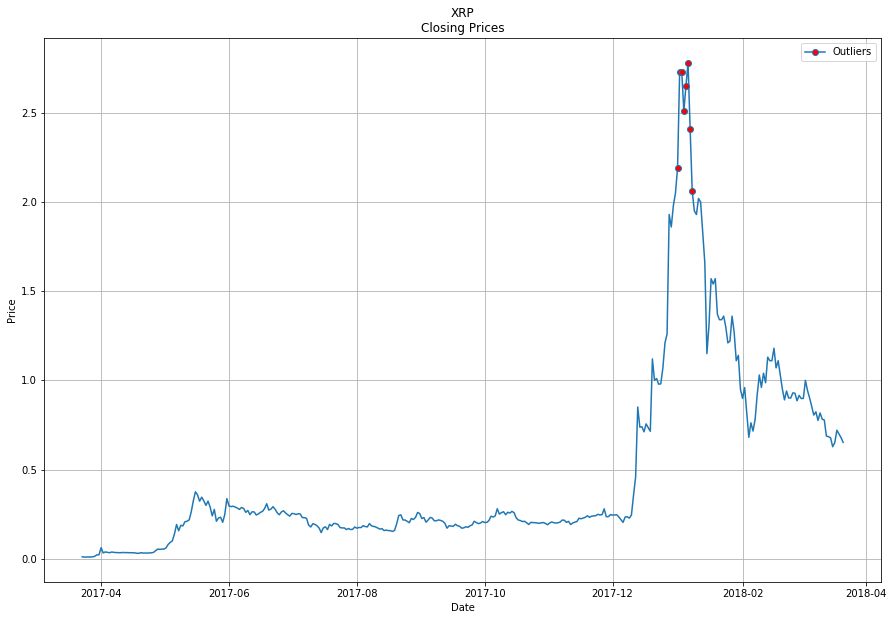

In [117]:
plt.figure(figsize=(15,10))
           
plt.plot(xrp_cleaned.index, xrp_cleaned.close, linestyle='solid', markevery=locs,
         marker='o', markerfacecolor='r', label='Outliers')

plt.title('XRP\nClosing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.grid()
plt.show()

In [119]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-10-07,11.80,11.95,10.62,11.78,1102329.22
2012-10-08,11.78,12.35,11.57,11.90,559694.91
2012-10-09,11.90,12.19,11.77,12.12,333351.59
2012-10-10,12.12,12.15,11.86,12.03,238483.07
2012-10-11,12.03,12.15,11.92,12.00,259522.53


/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


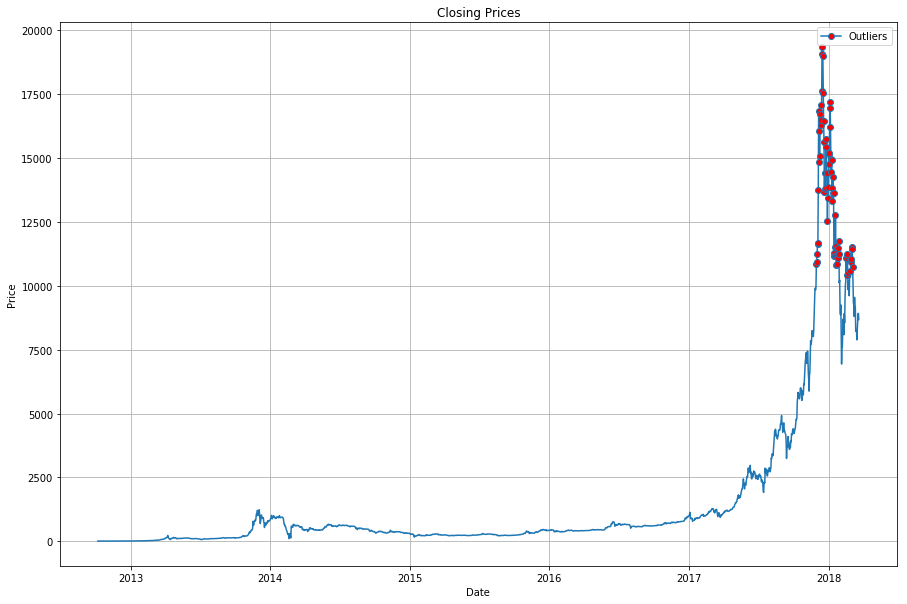

In [120]:
check_outliers(btc)

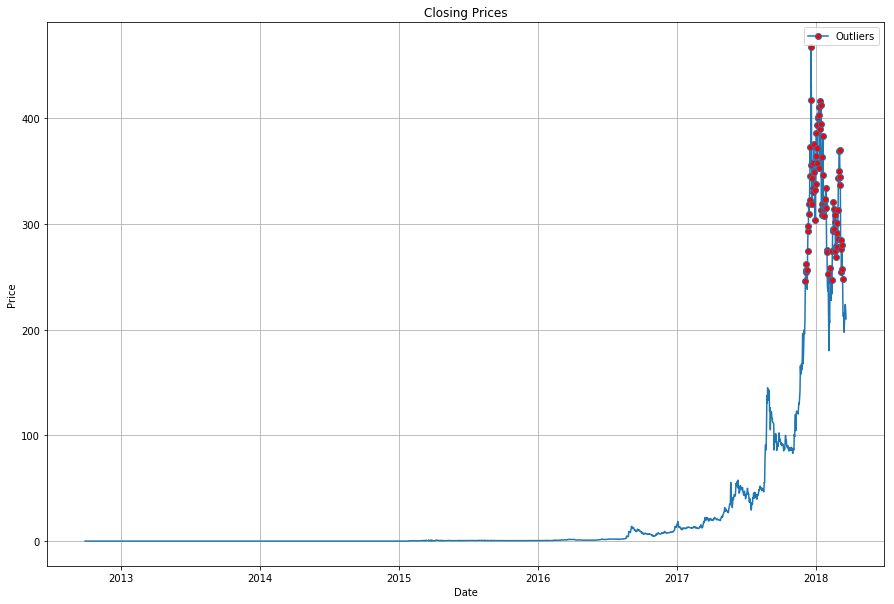

In [121]:
check_outliers(df_dict_crypto['XMR'])

In [123]:
xmr = df_dict_crypto['XMR']
xmr = clean_df_crypto(xmr)
xmr.head()

,open,high,low,close,volume
Date,,,,,
2017-03-09,13.10,13.62,12.15,13.03,1169823.65
2017-03-10,13.03,14.64,12.97,14.64,692636.89
2017-03-11,14.64,17.02,14.24,16.90,1944906.60
2017-03-12,16.90,19.47,16.11,18.49,2011183.69
2017-03-13,18.49,18.50,17.01,17.41,972535.54


/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


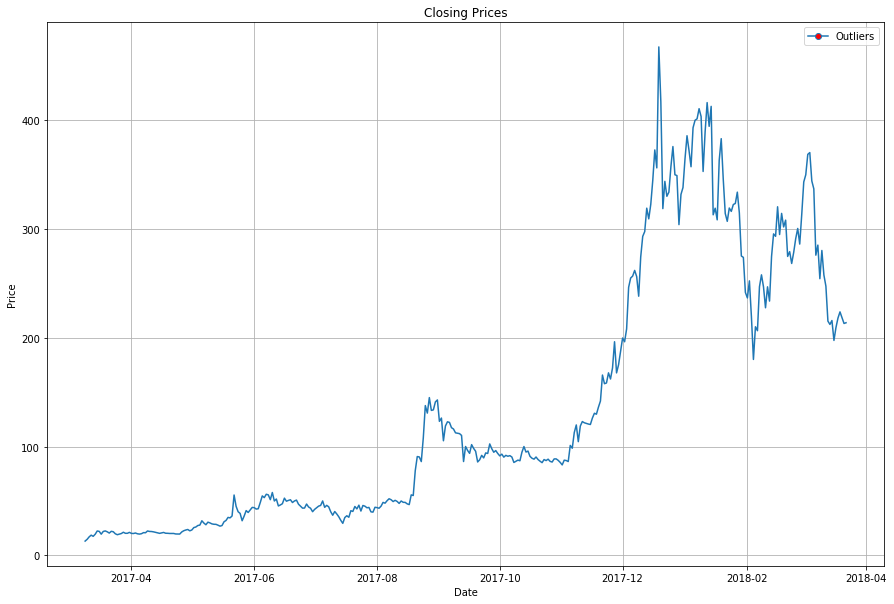

Number of data points: 379
Number of outliers: 0


In [126]:
check_outliers(xmr)

In [127]:
ltc = df_dict_crypto['LTC']
ltc = clean_df_crypto(ltc)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


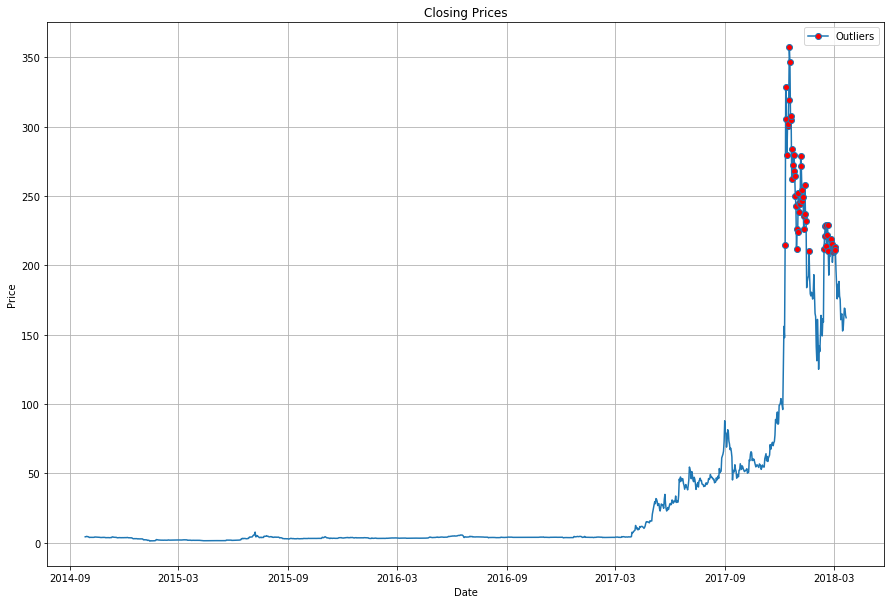

Number of data points: 1273
Number of outliers: 53


In [128]:
check_outliers(ltc)